<a href="https://colab.research.google.com/github/vedantipawar/Defense-against-Adversarial-Attacks/blob/main/ResNet34_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

# Model Zoo -- ResNet-34 MNIST Digits Classifier

### Network Architecture

The network in this notebook is an implementation of the ResNet-34 [1] architecture on the MNIST digits dataset (http://yann.lecun.com/exdb/mnist/) to train a handwritten digit classifier.  


References
    
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] http://yann.lecun.com/exdb/mnist/

![](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/images/resnets/resnet34/resnet34-arch.png?raw=1)


The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.

![](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/images/resnets/resnet-ex-1-1.png?raw=1)


The ResNet-34 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:

![](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/images/resnets/resnet-ex-1-2.png?raw=1)

For a more detailed explanation see the other notebook, [resnet-ex-1.ipynb](resnet-ex-1.ipynb).

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cpu"
GRAYSCALE = True

### MNIST Dataset

In [4]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 9912422/9912422 [00:00<00:00, 143283986.05it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46059199.17it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47393789.89it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13066206.29it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [5]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


The following code cell that implements the ResNet-34 architecture is a derivative of the code provided at https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html.

In [6]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [7]:
torch.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()
for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))



    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS,
              compute_accuracy(model, train_loader, device=DEVICE)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0469 | Cost: 2.5538
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.3831
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.0801
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.1263
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.2317
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.0828
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.0172
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.0922
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.0492
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.1163
Epoch: 001/010 | Train: 97.507%
Time elapsed: 25.26 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.0767
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.1245
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0891
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.0484
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.0192
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.0320
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.0917
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0254
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.0154
Epoch: 002/010 | Batch 0450/0469

## Evaluation

In [ ]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 99.10%


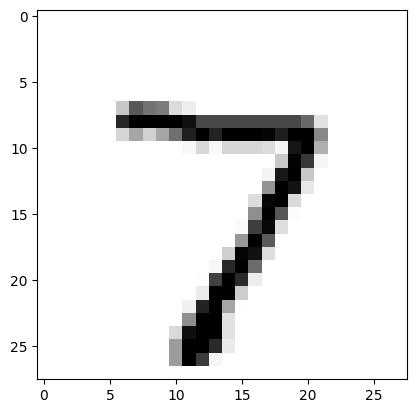

In [ ]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break


nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [ ]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%


## ART Attacks

In [11]:
pip install adversarial-robustness-toolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.3 MB/s eta 0:00:00


In [12]:
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method


In [14]:
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        logits, _ = self.model(x)  # Assuming the model returns logits and probabilities
        return logits


In [15]:
model.eval()  # Set the model to evaluation mode


wrapped_model = ModelWrapper(model)

# Wrap the PyTorch model with ART's PyTorchClassifier
classifier = PyTorchClassifier(
    model=wrapped_model,
    clip_values=(0, 1),
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=NUM_CLASSES,
    device_type=DEVICE
)



## FGSM Attack

In [ ]:
# # Get a single batch from the test_loader
# for images, labels in test_loader:
#     images_np = images.numpy()  # Convert to NumPy array
#     labels_np = labels.numpy()  # Convert to NumPy array
#     break  # We use only the first batch for this example

total_correct = 0
total_examples = 0

# Create FGSM attack
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.2)

# Ensure the model is in evaluation mode
model.eval()

for images, labels in test_loader:
    # Convert images to NumPy array for ART
    images_np = images.numpy()

    # Generate adversarial examples
    x_test_adv = fgsm_attack.generate(x=images_np)

    # Convert adversarial examples back to PyTorch tensors and move to the correct device
    x_test_adv_torch = torch.from_numpy(x_test_adv).to(DEVICE)
    labels = labels.to(DEVICE)

    # Perform inference on adversarial examples
    logits, _ = model(x_test_adv_torch)
    _, predictions = torch.max(logits, dim=1)

    # Update the accumulators
    total_correct += (predictions == labels).sum().item()
    total_examples += labels.size(0)

# Calculate the overall accuracy
accuracy_fgsm = total_correct / total_examples
print(f"Accuracy on C&W adversarial examples over the entire test set: {accuracy_fgsm * 100:.2f}%")



Accuracy on C&W adversarial examples over the entire test set: 18.19%


##PGD

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent, CarliniL2Method


ModuleNotFoundError: No module named 'art'

In [ ]:
total_correct = 0
total_examples = 0

# Create PGD attack
pgd_attack = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=40)

# Ensure the model is in evaluation mode
model.eval()

for images, labels in test_loader:
    # Convert images to NumPy array for ART
    images_np = images.numpy()

    # Generate adversarial examples with PGD
    x_test_adv_pgd = pgd_attack.generate(x=images_np)

    # Convert adversarial examples to torch tensors and move to the correct device
    x_test_adv_pgd_torch = torch.from_numpy(x_test_adv_pgd).to(DEVICE)
    labels = labels.to(DEVICE)

    # Perform inference on adversarial examples
    logits, _ = model(x_test_adv_pgd_torch)
    _, predictions = torch.max(logits, dim=1)

    # Update the accumulators
    total_correct += (predictions == labels).sum().item()
    total_examples += labels.size(0)

# Calculate the overall accuracy
accuracy_pgd = total_correct / total_examples
print(f"Accuracy on PGD adversarial examples over the entire test set: {accuracy_pgd * 100:.2f}%")


NameError: name 'ProjectedGradientDescent' is not defined

In [ ]:
total_correct = 0
total_examples = 0

# Create C&W L2 attack
cw_attack = CarliniL2Method(classifier=classifier, max_iter=100, binary_search_steps=5, learning_rate=0.01, batch_size=128)

# Ensure the model is in evaluation mode
model.eval()

for images, labels in test_loader:
    # Convert images to NumPy array for ART
    images_np = images.numpy()

    # Generate adversarial examples for the current batch
    x_test_adv = cw_attack.generate(x=images_np)

    # Convert adversarial examples back to PyTorch tensors and move to the correct device
    x_test_adv_torch = torch.from_numpy(x_test_adv).to(DEVICE)
    labels = labels.to(DEVICE)

    # Perform inference on adversarial examples
    logits, _ = model(x_test_adv_torch)
    _, predictions = torch.max(logits, dim=1)

    # Update the accumulators
    total_correct += (predictions == labels).sum().item()
    total_examples += labels.size(0)

# Calculate the overall accuracy
accuracy_cw = total_correct / total_examples
print(f"Accuracy on C&W adversarial examples over the entire test set: {accuracy_cw * 100:.2f}%")



NameError: name 'CarliniL2Method' is not defined

##CUTMIX

In [ ]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.9 MB/s eta 0:00:00


In [ ]:
import torch
from art.defences.preprocessor import CutMixPyTorch


In [ ]:
cutmix = CutMixPyTorch(num_classes=NUM_CLASSES, alpha=1.0, probability=0.5, channels_first=True, apply_fit=True, apply_predict=False, device_type='cpu', verbose=False)


In [ ]:
device = torch.device("cpu")  # or "cuda" if you're using GPU
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Apply CutMix augmentation
        inputs, targets = cutmix.forward(inputs, targets)

        # Forward pass
        outputs, _ = model(inputs)  # Adjust this line if your model returns logits and probas
        # If your model directly returns a tuple, make sure to select the logits part here

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [1/469], Loss: 2.5861
Epoch [1/10], Step [101/469], Loss: 0.9826
Epoch [1/10], Step [201/469], Loss: 1.0274
Epoch [1/10], Step [301/469], Loss: 0.8164
Epoch [1/10], Step [401/469], Loss: 0.7460
Epoch [2/10], Step [1/469], Loss: 0.8827
Epoch [2/10], Step [101/469], Loss: 0.6558
Epoch [2/10], Step [201/469], Loss: 0.7661
Epoch [2/10], Step [301/469], Loss: 0.7528
Epoch [2/10], Step [401/469], Loss: 0.4358
Epoch [3/10], Step [1/469], Loss: 0.6661
Epoch [3/10], Step [101/469], Loss: 0.6295
Epoch [3/10], Step [201/469], Loss: 0.8488
Epoch [3/10], Step [301/469], Loss: 0.8517
Epoch [3/10], Step [401/469], Loss: 0.8351
Epoch [4/10], Step [1/469], Loss: 0.1929
Epoch [4/10], Step [101/469], Loss: 0.3844
Epoch [4/10], Step [201/469], Loss: 0.7014
Epoch [4/10], Step [301/469], Loss: 0.7398
Epoch [4/10], Step [401/469], Loss: 0.8761
Epoch [5/10], Step [1/469], Loss: 0.5361
Epoch [5/10], Step [101/469], Loss: 0.8682
Epoch [5/10], Step [201/469], Loss: 0.5479
Epoch [5/10], Step [3

In [ ]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Inference mode, no gradients needed
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')


Accuracy of the model on the test images: 97.08%


In [ ]:
model.eval()  # Set the model to evaluation mode


wrapped_model = ModelWrapper(model)

# Wrap the PyTorch model with ART's PyTorchClassifier
classifier = PyTorchClassifier(
    model=wrapped_model,
    clip_values=(0, 1),
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=NUM_CLASSES,
    device_type=DEVICE
)


In [ ]:
# Initialize the FGSM attack
attack = FastGradientMethod(estimator=classifier, eps=0.2)

In [ ]:
# # Get a single batch from the test_loader
# for images, labels in test_loader:
#     images_np = images.numpy()  # Convert to NumPy array
#     labels_np = labels.numpy()  # Convert to NumPy array
#     break  # We use only the first batch for this example

total_correct = 0
total_examples = 0

# Create FGSM attack
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.2)

# Ensure the model is in evaluation mode
model.eval()

for images, labels in test_loader:
    # Convert images to NumPy array for ART
    images_np = images.numpy()

    # Generate adversarial examples
    x_test_adv = fgsm_attack.generate(x=images_np)

    # Convert adversarial examples back to PyTorch tensors and move to the correct device
    x_test_adv_torch = torch.from_numpy(x_test_adv).to(DEVICE)
    labels = labels.to(DEVICE)

    # Perform inference on adversarial examples
    logits, _ = model(x_test_adv_torch)
    _, predictions = torch.max(logits, dim=1)

    # Update the accumulators
    total_correct += (predictions == labels).sum().item()
    total_examples += labels.size(0)

# Calculate the overall accuracy
accuracy_fgsm = total_correct / total_examples
print(f"Accuracy on FGSM adversarial examples over the entire test set after using CUTMIX: {accuracy_fgsm * 100:.2f}%")



Accuracy on FGSM adversarial examples over the entire test set after using CUTMIX: 59.13%


In [20]:
from art.attacks.evasion import ProjectedGradientDescent

In [ ]:
total_correct = 0
total_examples = 0

# Create PGD attack
pgd_attack = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=40)

# Ensure the model is in evaluation mode
model.eval()

for images, labels in test_loader:
    # Convert images to NumPy array for ART
    images_np = images.numpy()

    # Generate adversarial examples with PGD
    x_test_adv_pgd = pgd_attack.generate(x=images_np)

    # Convert adversarial examples to torch tensors and move to the correct device
    x_test_adv_pgd_torch = torch.from_numpy(x_test_adv_pgd).to(DEVICE)
    labels = labels.to(DEVICE)

    # Perform inference on adversarial examples
    logits, _ = model(x_test_adv_pgd_torch)
    _, predictions = torch.max(logits, dim=1)

    # Update the accumulators
    total_correct += (predictions == labels).sum().item()
    total_examples += labels.size(0)

# Calculate the overall accuracy
accuracy_pgd = total_correct / total_examples
print(f"Accuracy on PGD adversarial examples over the entire test set after cutmix: {accuracy_pgd * 100:.2f}%")


##FEATRUE SQUEEZING

In [8]:
from google.colab import drive
drive.mount('/content/drive')
#checkpoint_path = "/content/drive/My Drive/ColabCheckpoints/my_model_checkpoint.pth"


Mounted at /content/drive


In [ ]:
from art.defences.preprocessor import FeatureSqueezing

# Initialize feature squeezing with a specific bit depth, e.g., reducing to 1 bit
# and assuming images are normalized to 0-1 range
feature_squeezing = FeatureSqueezing(clip_values=(0, 1), bit_depth=1)



In [ ]:
import torch
import os
device = torch.device("cpu")  # or "cuda" if you're using GPU
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

# Define your model, optimizer, and other configurations here

# Path to your checkpoint file
checkpoint_path = "/content/drive/MyDrive/my_model_checkpoint.pth"

# Function to save checkpoint
def save_checkpoint(state, filename=checkpoint_path):
    torch.save(state, filename)

# Function to load checkpoint
def load_checkpoint(filename=checkpoint_path):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}")
        return start_epoch
    else:
        return 0

# Load the checkpoint if it exists
start_epoch = load_checkpoint()
SAVE_FREQUENCY = 1  # Save the checkpoint after every epoch

# Training loop
for epoch in range(start_epoch, NUM_EPOCHS):
    # Your training process here
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Convert inputs to numpy arrays for feature squeezing
        inputs_np = inputs.cpu().numpy()

        # Apply Feature Squeezing
        squeezed_inputs_np, _ = feature_squeezing(inputs_np)

        # Convert squeezed inputs back to PyTorch tensors and move to the correct device
        squeezed_inputs = torch.tensor(squeezed_inputs_np).to(device)

        # Forward pass
        outputs, _ = model(squeezed_inputs)  # Ensure this line matches your model's output

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


    # Save checkpoint periodically or based on your criteria
    if (epoch + 1) % SAVE_FREQUENCY == 0:  # Assuming SAVE_FREQUENCY is defined
        save_checkpoint({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        })
        print(f"Checkpoint saved at epoch {epoch + 1}")


Epoch [1/10], Step [1/469], Loss: 0.0256
Epoch [1/10], Step [101/469], Loss: 0.0368
Epoch [1/10], Step [201/469], Loss: 0.0805
Epoch [1/10], Step [301/469], Loss: 0.0164
Epoch [1/10], Step [401/469], Loss: 0.0086
Checkpoint saved at epoch 1
Epoch [2/10], Step [1/469], Loss: 0.0023
Epoch [2/10], Step [101/469], Loss: 0.0112
Epoch [2/10], Step [201/469], Loss: 0.1020
Epoch [2/10], Step [301/469], Loss: 0.0176
Epoch [2/10], Step [401/469], Loss: 0.0291
Checkpoint saved at epoch 2
Epoch [3/10], Step [1/469], Loss: 0.0200
Epoch [3/10], Step [101/469], Loss: 0.0625
Epoch [3/10], Step [201/469], Loss: 0.0045
Epoch [3/10], Step [301/469], Loss: 0.0061
Epoch [3/10], Step [401/469], Loss: 0.0897
Checkpoint saved at epoch 3
Epoch [4/10], Step [1/469], Loss: 0.0066
Epoch [4/10], Step [101/469], Loss: 0.0129
Epoch [4/10], Step [201/469], Loss: 0.0144
Epoch [4/10], Step [301/469], Loss: 0.0027
Epoch [4/10], Step [401/469], Loss: 0.0071
Checkpoint saved at epoch 4
Epoch [5/10], Step [1/469], Loss: 0.

In [9]:
# Load the model weights
checkpoint_path = "/content/drive/MyDrive/my_model_checkpoint.pth"
def load_checkpoint(filename=checkpoint_path):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        # If optimizer state is needed, load it here
        print("Checkpoint loaded.")
    else:
        print("No checkpoint found at:", filename)

load_checkpoint()

Checkpoint loaded.


In [10]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Inference mode, no gradients needed
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')


Accuracy of the model on the test images: 99.16%


### FGSM ATTACK after Feature squeezing

In [16]:
# Initialize the FGSM attack
attack = FastGradientMethod(estimator=classifier, eps=0.2)

In [17]:
# # Get a single batch from the test_loader
# for images, labels in test_loader:
#     images_np = images.numpy()  # Convert to NumPy array
#     labels_np = labels.numpy()  # Convert to NumPy array
#     break  # We use only the first batch for this example

total_correct = 0
total_examples = 0

# Create FGSM attack
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.2)

# Ensure the model is in evaluation mode
model.eval()

for images, labels in test_loader:
    # Convert images to NumPy array for ART
    images_np = images.numpy()

    # Generate adversarial examples
    x_test_adv = fgsm_attack.generate(x=images_np)

    # Convert adversarial examples back to PyTorch tensors and move to the correct device
    x_test_adv_torch = torch.from_numpy(x_test_adv).to(DEVICE)
    labels = labels.to(DEVICE)

    # Perform inference on adversarial examples
    logits, _ = model(x_test_adv_torch)
    _, predictions = torch.max(logits, dim=1)

    # Update the accumulators
    total_correct += (predictions == labels).sum().item()
    total_examples += labels.size(0)

# Calculate the overall accuracy
accuracy_fgsm_featuresqueezed = total_correct / total_examples
print(f"Accuracy on FGSM adversarial examples over the entire test set after using Feature Squeezing: {accuracy_fgsm_featuresqueezed* 100:.2f}%")



Accuracy on FGSM adversarial examples over the entire test set after using Feature Squeezing: 25.04%


In [18]:
import json

def save_progress(checkpoint_path_fs_pgd, total_correct, total_examples, last_index):
    progress = {
        'total_correct': total_correct,
        'total_examples': total_examples,
        'last_index': last_index
    }
    with open(checkpoint_path, 'w') as f:
        json.dump(progress, f)


In [19]:
def load_progress(checkpoint_path_fs_pgd):
    try:
        with open(checkpoint_path_fs_pgd, 'r') as f:
            progress = json.load(f)
            return progress['total_correct'], progress['total_examples'], progress['last_index']
    except FileNotFoundError:
        return 0, 0, -1  # If file doesn't exist, start from scratch


In [ ]:
checkpoint_path_fs_pgd = "/content/drive/MyDrive/pgd_progress.json"
total_correct, total_examples, last_processed_index = load_progress(checkpoint_path_fs_pgd)
pgd_attack = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=40)

model.eval()  # Ensure the model is in evaluation mode

for idx, (images, labels) in enumerate(test_loader):
    if idx <= last_processed_index:
        continue  # Skip already processed batches

    # Convert images to NumPy array for ART
    images_np = images.numpy()

    # Generate adversarial examples with PGD
    x_test_adv_pgd = pgd_attack.generate(x=images_np)

    # Convert adversarial examples to torch tensors and move to the correct device
    x_test_adv_pgd_torch = torch.from_numpy(x_test_adv_pgd).to(DEVICE)
    labels = labels.to(DEVICE)

    # Perform inference on adversarial examples
    logits, _ = model(x_test_adv_pgd_torch)
    _, predictions = torch.max(logits, dim=1)

    # Update the accumulators
    total_correct += (predictions == labels).sum().item()
    total_examples += labels.size(0)


    # Update and save progress periodically or after every batch
    save_progress(checkpoint_path_fs_pgd, total_correct, total_examples, idx)

accuracy_pgd = total_correct / total_examples
print(f"Accuracy on PGD adversarial examples over the entire test set after feature squeezing: {accuracy_pgd * 100:.2f}%")


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]